<hr style="height:2px;">

# Apply trained CARE model for for denoising of *X-ray Holographic Nanotomography* data

Adapted from demo notebook. 

This notebook demonstrates applying a CARE model for a 3D denoising task, assuming that training was already completed via [2_training.ipynb](2_training.ipynb).  
The trained model is assumed to be located in the folder `models` with the name `my_model`.

More documentation is available at http://csbdeep.bioimagecomputing.com/doc/.

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file, plot_some
from csbdeep.io import save_tiff_imagej_compatible
from csbdeep.models import CARE

2021-07-20 10:36:30.199711: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# SET DATA PATH
datapath = "/home/jrho/XNH/JanXrayData/CARE/mCTX/"

<hr style="height:2px;">

# Raw low-SNR image and associated high-SNR ground truth

Plot the test stack pair and define its image axes, which will be needed later for CARE prediction.

image size = (256, 512, 512)
image axes = ZYX


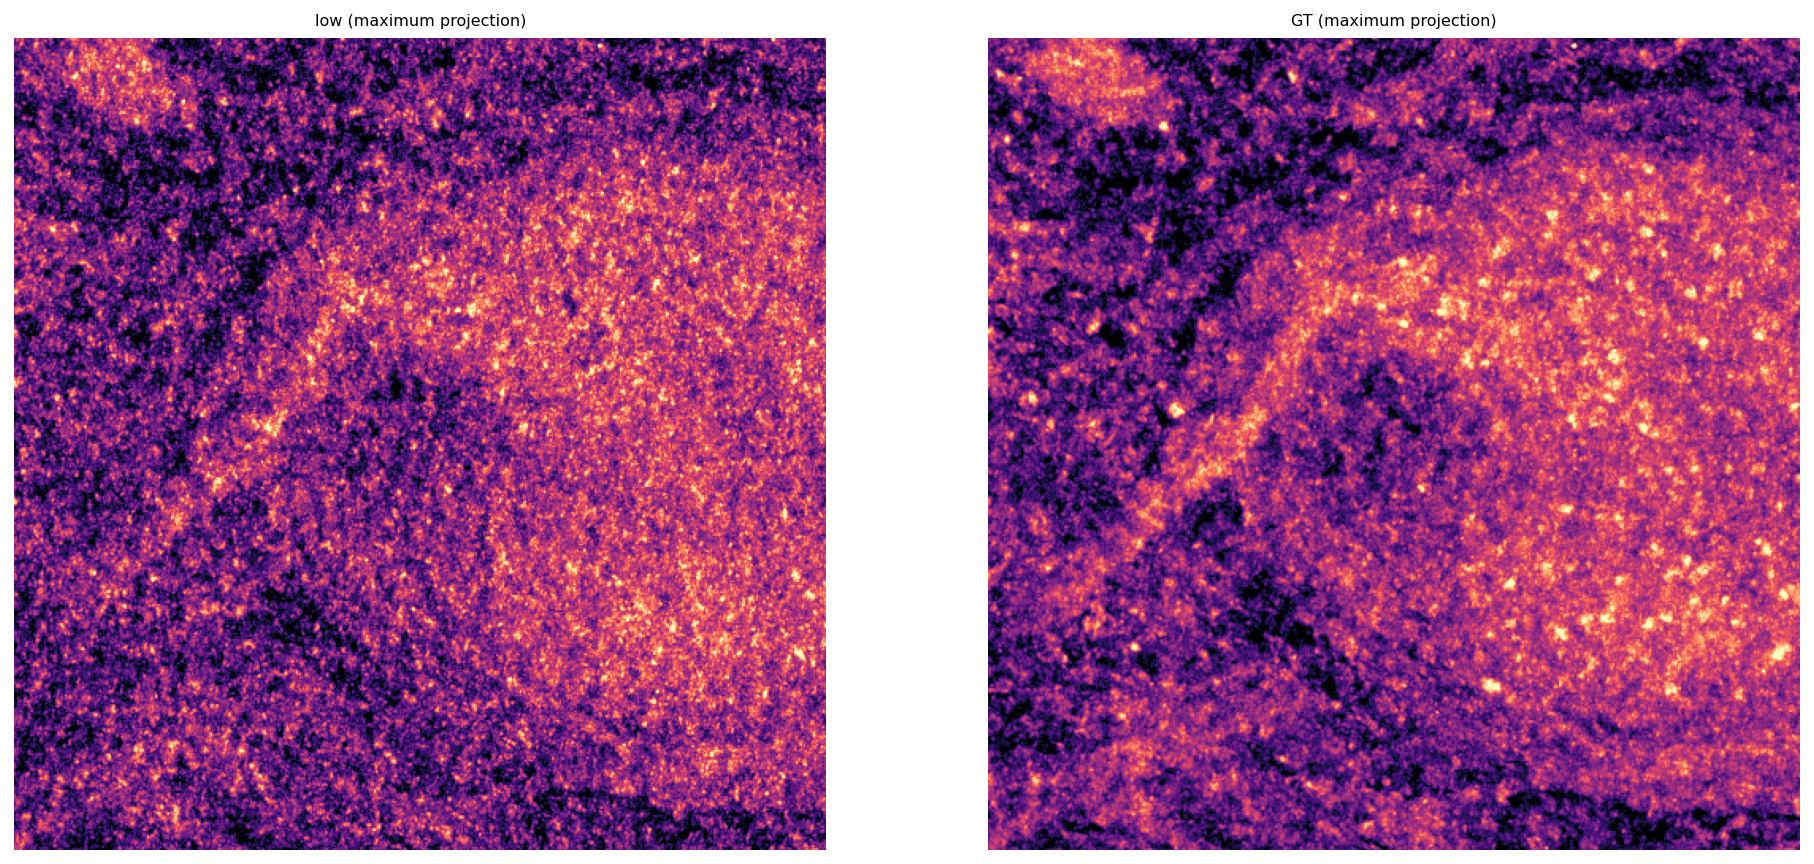

In [3]:
y = imread(datapath + 'test/GT/mCTX_17keV_30nm_512c_first256.tif')
x = imread(datapath + 'test/low/mCTX_17keV_30nm_512c_first256_450p.tif')

axes = 'ZYX'
print('image size =', x.shape)
print('image axes =', axes)

plt.figure(figsize=(16,10))
plot_some(np.stack([x,y]),
          title_list=[['low (maximum projection)','GT (maximum projection)']], 
          pmin=2,pmax=99.8);

<hr style="height:2px;">

# CARE model

Load trained model (located in base directory `models` with name `my_model`) from disk.  
The configuration was saved during training and is automatically loaded when `CARE` is initialized with `config=None`.

In [4]:
model = CARE(config=None, name='my_model_450p', basedir='models')

2021-07-20 10:36:52.295087: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-20 10:36:52.332088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-20 10:36:52.332642: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: NVIDIA GeForce RTX 2080 computeCapability: 7.5
coreClock: 1.71GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.23GiB/s
2021-07-20 10:36:52.332688: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-20 10:36:52.382845: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-20 10:36:52.383011: I tensorflow/stream_executor/plat

## Apply CARE network to raw image

Predict the restored image (image will be successively split into smaller tiles if there are memory issues).

In [5]:
%%time
restored = model.predict(x, axes)

ore/common_runtime/bfc_allocator.cc:1054] 2 Chunks of size 884736 totalling 1.69MiB
2021-07-20 10:39:59.964757: I tensorflow/core/common_runtime/bfc_allocator.cc:1054] 1 Chunks of size 1327104 totalling 1.27MiB
2021-07-20 10:39:59.964775: I tensorflow/core/common_runtime/bfc_allocator.cc:1054] 1 Chunks of size 80281600 totalling 76.56MiB
2021-07-20 10:39:59.964794: I tensorflow/core/common_runtime/bfc_allocator.cc:1054] 1 Chunks of size 321126400 totalling 306.25MiB
2021-07-20 10:39:59.964811: I tensorflow/core/common_runtime/bfc_allocator.cc:1054] 2 Chunks of size 2569011200 totalling 4.79GiB
2021-07-20 10:39:59.964829: I tensorflow/core/common_runtime/bfc_allocator.cc:1058] Sum Total of in-use chunks: 5.16GiB
2021-07-20 10:39:59.964847: I tensorflow/core/common_runtime/bfc_allocator.cc:1060] total_region_allocated_bytes_: 6237257728 memory_limit_: 6237257728 available bytes: 0 curr_region_allocation_bytes_: 12474515456
2021-07-20 10:39:59.964873: I tensorflow/core/common_runtime/bfc_

Alternatively, one can directly set `n_tiles` to avoid the time overhead from multiple retries in case of memory issues.

**Note**: *Out of memory* problems during `model.predict` can also indicate that the GPU is used by another process. In particular, shut down the training notebook before running the prediction (you may need to restart this notebook).

In [ ]:
%%time
restored = model.predict(x, axes, n_tiles=(1,4,4))

## Save restored image

Save the restored image stack as a ImageJ-compatible TIFF image, i.e. the image can be opened in ImageJ/Fiji with correct axes semantics.

In [7]:
Path('results').mkdir(exist_ok=True)
save_tiff_imagej_compatible(datapath+'results/%s_mCTX_17keV_30nm_512c.tif' % model.name, restored, axes)

<hr style="height:2px;">

# Raw low/high-SNR image and denoised image via CARE network

Plot the test stack pair and the predicted restored stack (middle).

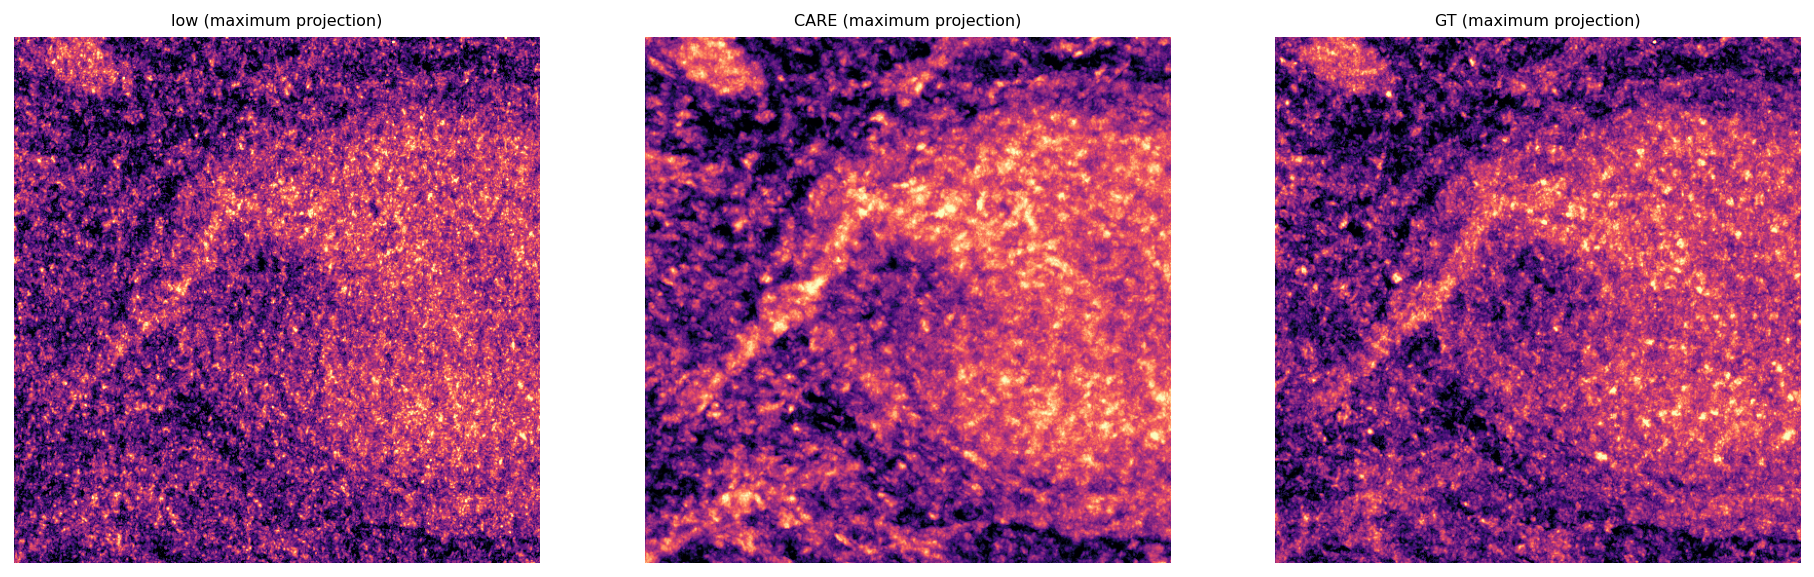

In [8]:
plt.figure(figsize=(16,10))
plot_some(np.stack([x,restored,y]),
          title_list=[['low (maximum projection)','CARE (maximum projection)','GT (maximum projection)']], 
          pmin=2,pmax=99.8);